### Investigating words meaning change

In this part we are computing number of features to evaluate shift in the word meaning from pre-Soviet through Soviet and to post-Soviet periods. This features are: 
1. cosine distance between second order word similarity vectors in two models,using the Global Anchors algorithm;
2. cosine distance between embeddings of the word after aligning two models, using the orthogonal Procrustes transformation;
3. Jaccard distance between top n neighbour lists of one and the same word in two models;
4. Kendall’s 𝜏 between top n neighbour lists of one and the same word in two models;

We are using computed features to learn logistic regression model. We are using hand-labeled linguistic data set(https://github.com/wadimiusz/diachrony_for_russian/) with words that have and haven't changed their meaning through Soviet times as target for our model. 

In [5]:
from gensim.models import word2vec
from sklearn.metrics.pairwise import cosine_similarity
import gensim
import numpy as np
from gensim.matutils import unitvec
from scipy.stats import mstats
from pymystem3 import Mystem
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora
from gensim.utils import simple_preprocess
from smart_open import smart_open
import os
from gensim.models import word2vec
from gensim.test.utils import get_tmpfile
import math
import scipy as sp
from scipy.sparse.linalg import svds
from gensim.models.word2vec import LineSentence
from gensim.test.utils import datapath
import tqdm
from gensim.models import KeyedVectors

from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from sklearn.externals import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score

/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [73]:
pip install pymystem3 

Note: you may need to restart the kernel to use updated packages.


In [74]:
!pip install utils

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


Loading hand-labeled data set

In [6]:
import pandas as pd  
data_macro = pd.read_csv("macro.csv") 

In [7]:
for i in range(215):
    data_macro.WORD[i] = data_macro.WORD[i].split('_')[0]

/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
data_macro

WORD  GROUND_TRUTH
0     отделение           1.0
1        секция           1.0
2        палата           1.0
3    богадельня           1.0
4         особа           1.0
..          ...           ...
210    условный           0.0
211  письменный           0.0
212    шелковый           0.0
213     тусклый           0.0
214    закрытый           0.0

[215 rows x 2 columns]

Function that looks for words accuring in 2 periods we are concerning and in hand-labeled data set.

In [9]:
def build_word_pairs_test(model_old, model_new, data_macro):
    #pairs = []
    pairs_test = []
    #old_vectors = []
    #new_vectors = []
    for word in model_old.wv.vocab:
        if word not in model_new:
            continue
        if word in list(data_macro.WORD):
            pairs_test.append((word))
        #pairs.append((word))
        #old_vectors.append(model_old[word])
        #new_vectors.append(model_new[word])
    return pairs_test

Function that looks for words accuring in 2 periods we are concerning.

In [10]:
def build_word_pairs_test_(model_old, model_new):
    pairs = []
    #pairs_test = []
    #old_vectors = []
    #new_vectors = []
    for word in model_old.wv.vocab:
        if word not in model_new:
            continue
        pairs.append((word))
        #old_vectors.append(model_old[word])
        #new_vectors.append(model_new[word])
    return pairs

Following functions were borrowed from github of one of the articles we reffered to in the begining: https://github.com/wadimiusz/diachrony_for_russian/

In [11]:
def intersection_align_gensim(m1: gensim.models.KeyedVectors, m2: gensim.models.KeyedVectors,
                              pos_tag: (str, None) = None, words: (list, None) = None):
    """
    This procedure, taken from https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf and slightly
    modified, corrects two models in a way that only the shared words of the vocabulary are kept in the model,
    and both vocabularies are sorted by frequencies.
    Original comment is as follows:

    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new vectors and vectors_norm objects in both gensim models:
        -- so that Row 0 of m1.vectors will be for the same word as Row 0 of m2.vectors
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.

    :param m1: the first model
    :param m2: the second model
    :param pos_tag: if given, we remove words with other pos tags
    :param words: a container
    :return m1, m2: both models after their vocabs are modified
    """

    # Get the vocab for each model
    if pos_tag is None:
        vocab_m1 = set(m1.vocab.keys())
        vocab_m2 = set(m2.vocab.keys())
    else:
        vocab_m1 = set(word for word in m1.vocab.keys() if word.endswith("_" + pos_tag))
        vocab_m2 = set(word for word in m2.vocab.keys() if word.endswith("_" + pos_tag))

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words:
        common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return m1, m2

    # Otherwise sort lexicographically
    common_vocab = list(common_vocab)
    common_vocab.sort()

    # Then for each model...
    for m in (m1, m2):
        # Replace old vectors_norm array with new one (with common vocab)
        indices = [m.vocab[w].index for w in common_vocab]
        old_arr = m.vectors_norm
        new_arr = np.array([old_arr[index] for index in indices])
        m.vectors_norm = m.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.vocab
        new_vocab = dict()
        for new_index, word in enumerate(common_vocab):
            old_vocab_obj = old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.vocab = new_vocab

    return m1, m2

In [12]:
def smart_procrustes_align_gensim(base_embed: gensim.models.KeyedVectors,
                                  other_embed: gensim.models.KeyedVectors):
    """
    This code, taken from
    https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf and modified,
    uses procrustes analysis to make two word embeddings compatible.
    :param base_embed: first embedding
    :param other_embed: second embedding to be changed
    :return other_embed: changed embedding
    """
    base_embed.init_sims()
    other_embed.init_sims()

    base_vecs = base_embed.syn0norm
    other_vecs = other_embed.syn0norm

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs)
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v)
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.syn0norm = other_embed.syn0 = other_embed.syn0norm.dot(ortho)

    return other_embed

Procrustes alignment is an SVD-based orthogonal transformation used
to as closely as possible ‘align’ one embedding space to another. After this,
one can calculate cosine distances between word embeddings from different models, as if they were trained together. 

In [13]:
class ProcrustesAligner(object):
    def __init__(self, w2v1: gensim.models.KeyedVectors, w2v2: gensim.models.KeyedVectors):
        self.w2v1, self.w2v2 = intersection_align_gensim(w2v1, w2v2)
        self.w2v2_changed = smart_procrustes_align_gensim(w2v1, w2v2)

    def __repr__(self):
        return "ProcrustesAligner"

    def get_score(self, word):
        vector1 = self.w2v1.wv[word]
        vector2 = self.w2v2_changed.wv[word]
        score = np.dot(vector1, vector2)  # More straightforward computation
        return score

    def get_changes(self, top_n_changed_words: int):
        log('Doing procrustes')
        result = list()
        # their vocabs should be the same, so it doesn't matter over which to iterate:
        for word in self.w2v1.wv.vocab.keys():
            score = self.get_score(word)
            result.append((word, score))

        result = sorted(result, key=lambda x: x[1])
        result = result[:top_n_changed_words]
        log('Done')
        return result

The Global Anchors algorithm measures how
much the lists of word cosine similarities to other ‘anchor words’ are different between two models. In the case of global anchors, these lists are simply full intersection
of two models’ vocabularies, and thus it allows to analyse how the word position has
changed related to all other words in the model.

In [14]:
class GlobalAnchors(object):
    def __init__(self, w2v1, w2v2, assume_vocabs_are_identical=False):
        if not assume_vocabs_are_identical:
            w2v1, w2v2 = intersection_align_gensim(w2v1, w2v2)
        
        self.w2v1 = w2v1
        self.w2v2 = w2v2

    def __repr__(self):
        return "GlobalAnchors"

    def get_global_anchors(self, word: str, w2v: gensim.models.KeyedVectors):
        """
        This takes in a word and a KeyedVectors model and returns a vector of cosine distances
        between this word and each word in the vocab.
        :param word:
        :param w2v:
        :return: np.array of distances shaped (len(w2v.vocab),)
        """
        word_vector = w2v.get_vector(word)
        similarities = gensim.models.KeyedVectors.cosine_similarities(word_vector, w2v.vectors)
        return unitvec(similarities)

    def get_score(self, word: str):
        w2v1_anchors = self.get_global_anchors(word, self.w2v1)
        w2v2_anchors = self.get_global_anchors(word, self.w2v2)

        score = np.dot(w2v1_anchors, w2v2_anchors)
        return score

    def get_changes(self, top_n_changed_words: int):
        """
        This method uses approach described in
        Yin, Zi, Vin Sachidananda, and Balaji Prabhakar.
        "The global anchor method for quantifying linguistic shifts and
        domain adaptation." Advances in Neural Information Processing Systems. 2018.
        It can be described as follows. To evaluate how much the meaning of a given word differs in
        two given corpora, we take cosine distance from the given word to all words
        in the vocabulary; those values make up a vector with as many components as there are words
        in the vocab. We do it for both corpora and then compute the cosine distance
        between those two vectors
        :param top_n_changed_words: we will output n words that differ the most in the given corpora
        :return: list of pairs (word, score), where score indicates how much a word has changed
        """
        log('Doing global anchors')
        result = list()
        for num, word in enumerate(self.w2v1.wv.vocab.keys()):
            if num % 10 == 0:
                log("{num} / {length}".format(num=num, length=len(self.w2v1.wv.vocab)), end='\r')

            score = self.get_score(word)
            result.append((word, score))

        result = sorted(result, key=lambda x: x[1])
        result = result[:top_n_changed_words]
        log('\nDone')
        return result

Jaccard distance is a metrics used to measure the diversity between samples
(here, samples are lists of a word’s nearest neighbours in a given model by cosine
similarity). It is defined as the difference of the samples’ union and intersection sizes
divided by the size of the union of two samples. 

In [15]:
class Jaccard(object):
    def __init__(self, w2v1: gensim.models.KeyedVectors, w2v2: gensim.models.KeyedVectors,
                 top_n_neighbors: int):

        self.w2v1 = w2v1
        self.w2v2 = w2v2
        self.top_n_neighbors = top_n_neighbors

    def __repr__(self):
        return "Jaccard"

    def get_score(self, word: str):
        top_n_1 = [word for word, score in self.w2v1.most_similar(word, topn=self.top_n_neighbors)]
        top_n_2 = [word for word, score in self.w2v2.most_similar(word, topn=self.top_n_neighbors)]
        if len(top_n_1) == self.top_n_neighbors and len(top_n_2) == self.top_n_neighbors:
            intersection = set(top_n_1).intersection(set(top_n_2))
            union = set(top_n_1 + top_n_2)
            score = len(intersection) / len(union)
            return score
        else:
            raise ValueError("Problem with {word} and its neighbours".format(word=word))

    def get_changes(self, top_n_changed_words: int):
        log('Doing jaccard')
        result = list()
        for num, word in enumerate(self.w2v1.wv.vocab):
            if num % 10 == 0:
                log("{words_num} / {length}".format(
                    words_num=num, length=len(self.w2v1.wv.vocab.keys())), end='\r')

            score = self.get_score(word=word)
            result.append((word, score))

        result = sorted(result, key=lambda x: x[1])[:top_n_changed_words]
        log('\nDone')
        return result

Kendall’s 𝜏 coefficient measures the
rank correlation of intersections of two words’ neighbours’ lists. Its main difference
in comparison to Jaccard distance when applied to our task, is that it pays attention
to the relative order of n nearest neighbours in two models, not only the size of their
intersection.

In [16]:
class KendallTau(object):
    def __init__(self, w2v1: gensim.models.KeyedVectors, w2v2: gensim.models.KeyedVectors,
                 top_n_neighbors):
        """
        :param w2v1: the model in question. if present, we use the index from that model
        :param w2v2: if word not present in w2v1, we look it up in the second model, w2v2
        """
        self.w2v1 = w2v1
        self.w2v2 = w2v2
        self.top_n_neighbors = top_n_neighbors

    def __repr__(self):
        return "KendallTau"

    def word_index(self, word: str) -> int:
        """
        A handy function for extracting the word index from models
        :param word: word the index of which we extract
        :return: the index of the word, an integer
        """
        if word in self.w2v1.wv:
            return self.w2v1.wv.vocab[word].index
        else:
            return len(self.w2v1.wv.vocab) + self.w2v2.wv.vocab[word].index

    def get_score(self, word: str):
        top_n_1 = [word for word, score in self.w2v1.most_similar(word, topn=self.top_n_neighbors)]
        top_n_2 = [word for word, score in self.w2v2.most_similar(word, topn=self.top_n_neighbors)]
        if len(top_n_1) == len(top_n_2) == self.top_n_neighbors:
            top_n_1 = [self.word_index(word) for word in top_n_1]
            top_n_2 = [self.word_index(word) for word in top_n_2]
            score, p_value = mstats.kendalltau(top_n_1, top_n_2)
            return score
        else:
            raise ValueError("Problem with word {word} and its neighbours".format(word=word))

    def get_changes(self, top_n_changed_words: int):
        log('Doing kendall tau')
        result = list()
        for num, word in enumerate(self.w2v1.wv.vocab.keys()):
            if num % 10 == 0:
                log("{words_num} / {length}".format(words_num=num, length=len(self.w2v1.wv.vocab)),
                    end='\r')

            score = self.get_score(word)
            result.append((word, score))

        result = sorted(result, key=lambda x: x[1])[:top_n_changed_words]
        log('\nDONE')
        return result

Now we are going to consern w2v model for stemmed data, so, we need to stemm hand-labled data set as well:

In [17]:
from nltk.stem.snowball import RussianStemmer
ru_stemmer = RussianStemmer()
data_macro.WORD = [ru_stemmer.stem(token) for token in data_macro.WORD]

In [18]:
data_macro

WORD  GROUND_TRUTH
0      отделен           1.0
1         секц           1.0
2        палат           1.0
3    богадельн           1.0
4         особ           1.0
..         ...           ...
210     условн           0.0
211    письмен           0.0
212     шелков           0.0
213      тускл           0.0
214     закрыт           0.0

[215 rows x 2 columns]

Loading word2vec model, calculating features, training LogisticRegression model:

In [19]:
model_old_ = Word2Vec.load("word2vec_0_300_10_5_stem.model")
model_new_ = Word2Vec.load("word2vec_2_300_10_5_stem.model")
pairs_test = build_word_pairs_test(model_old_, model_new_, data_macro)

model_old_.wv.init_sims() 
model_new_.wv.init_sims()
x = np.zeros((len(pairs_test), 4))
y = np.zeros(len(pairs_test))
x_ = np.zeros((len(pairs_test), 5))

for i in range(len(pairs_test)):
    #print("Procrustes aligner score: {} (from -1 to 1)".format(
     #   ProcrustesAligner(model_old_.wv, model_new_.wv).get_score(pairs_test[i])))
    #print("Global Anchors score: {} (from -1 to 1)".format(
     #   GlobalAnchors(model_old_.wv, model_new_.wv).get_score(pairs_test[i])))
    #print("KendallTau score: {} (from -1 to 1)".format(
     #   KendallTau(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])))
    #print("Jaccard score: {} (from 0 to 1)".format(
     #   Jaccard(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])))
    
    x[i,0] = ProcrustesAligner(model_old_.wv, model_new_.wv).get_score(pairs_test[i])
    x[i,1] = GlobalAnchors(model_old_.wv, model_new_.wv).get_score(pairs_test[i])
    x[i,2] = KendallTau(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])
    x[i,3] = Jaccard(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])
    y[i] = data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == pairs_test[i]].tolist()[0]]

/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  from ipykernel import kernelapp as app
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationW

In [20]:
len(pairs_test)

190

In [21]:
y.sum()

30.0

Classification with logistic regression:
It is also important to mention, that model trains not on all the words, but on part of them, that data is not too imbalanced, the relation between 1 and 0 results was estimated experimentally.

In [22]:
xb = np.zeros((int(y.sum()*4),x.shape[1]))
yb = np.zeros((int(y.sum()*4)))
j = 0
num = 0
for i in range(y.shape[0]):
    if (y[i] == 1): 
        yb[j] = y[i]
        xb[j] = x[i]
        j += 1
    if (y[i] == 0) and (num < int(y.sum()*3)):
        yb[j] = y[i]
        xb[j] = x[i]
        j += 1
        num += 1 
        
x_train, x_test, y_train, y_test = train_test_split(xb[:,:2], yb, test_size=0.25, stratify = yb, random_state=42)

clf_logreg = LogisticRegressionCV()
clf_logreg.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [23]:
print('roc_auc', roc_auc_score(y_train, clf_logreg.predict(x_train)))
print('roc_auc', roc_auc_score(y_test, clf_logreg.predict(x_test)))
print('roc_auc', roc_auc_score(y, clf_logreg.predict(x[:,:2])))

roc_auc 0.7024659312134978
roc_auc 0.8354037267080746
roc_auc 0.6968750000000001


As you can see, in this model we don't consider Jaccard distance and Kendall’s 𝜏. Such combination was estimated experimentally and leads to the best score.
Also, from the following correlation matrix one can see, that Procrustes and GlobalAnchors influense the change more than other features.  This emphasises the importance of taking into account the word ‘trajectory’ in relation to the whole vector space, when trying to detect slight social and cultural changes.

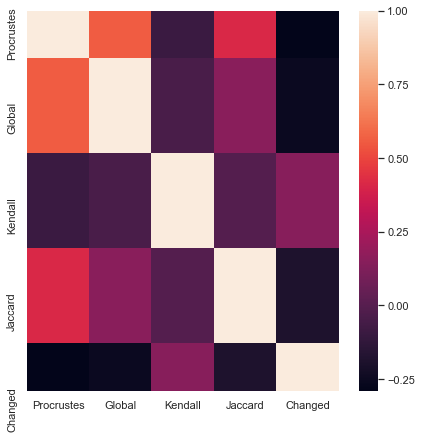

In [25]:
import seaborn as sns

sns.set(rc={'figure.figsize':(7,7)})

data1 = {'Procrustes':x[:,0], 'Global':x[:,1], 'Kendall':x[:,2], 'Jaccard':x[:,3], 'Changed':y} 
   
shifts1 = pd.DataFrame(data1)  

correlation = shifts1.corr()
sns.heatmap(correlation)

In [26]:
numbers = []
i = 0
for word in pairs_test:
    if(data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == word].tolist()[0]] == 1):
        #print (word)# data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == word].tolist()])
        numbers.append(i)
    i += 1

i = 0
for word in pairs_test:
    if(data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == word].tolist()[0]] == 1):
        print (word, x[i,0], 1)
    else:
        print (word, x[i,0], 0)
    i += 1

план 0.36427611112594604 0
цел 0.40947359800338745 0
образ 0.2890971601009369 0
свет 0.4465633034706116 0
стран 0.3902757465839386 0
кра 0.3691493272781372 0
весн 0.39502447843551636 0
смерт 0.4581960439682007 0
старушк 0.39101558923721313 0
земл 0.5388766527175903 0
жен 0.43878281116485596 0
добр 0.40393397212028503 0
вечер 0.4724304974079132 0
предложен 0.432156503200531 0
ласков 0.3328525722026825 0
им 0.3931393027305603 0
стат 0.36720311641693115 0
роз 0.3691602945327759 0
желан 0.3812020421028137 0
минут 0.45295166969299316 0
мечт 0.4411720037460327 0
последн 0.4105711579322815 0
десяток 0.31247708201408386 0
месяц 0.4579356610774994 0
зло 0.36890971660614014 0
соглас 0.35051843523979187 0
спокойств 0.36460983753204346 0
пламен 0.42737725377082825 0
войн 0.36639103293418884 0
служб 0.2901090681552887 0
полк 0.3182309567928314 0
зал 0.4031856954097748 0
пост 0.298592209815979 0
карт 0.3246802091598511 0
власт 0.47438234090805054 0
произведен 0.38706403970718384 0
област 0.375287175

Words that seems to change their meaning in our model and marked to change their meaning in labled data set

In [27]:
i = 0
for word in pairs_test:
    if(data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == word].tolist()[0]] == 1):
        if (x[numbers[i],0] < x[:,0].sum()/x.shape[0]):
            print (word, x[numbers[i],0])
        i += 1

защитник 0.2599492073059082
заключен 0.25685644149780273
молодец 0.3518037796020508
управлен 0.3197025656700134
червяк 0.2040824592113495
палат 0.23679712414741516
отделен 0.2945514917373657
директор 0.29674315452575684
чиновник 0.35289978981018066
тетк 0.2867963910102844
уклон 0.2974328398704529
пакет 0.23056510090827942
казен 0.35089224576950073
правител 0.32800614833831787
завед 0.2870643436908722
дум 0.1718900352716446
передов 0.2812347114086151
отдел 0.15960785746574402
тройк 0.311029851436615
машин 0.3149896264076233
привет 0.2682870924472809
сволоч 0.28215309977531433


In [97]:
model_old_.wv.most_similar('дум')

[('отвеч', 0.3280586004257202),
 ('раздумыва', 0.29585373401641846),
 ('сумеречн', 0.2893873453140259),
 ('неразрешим', 0.28908872604370117),
 ('безысходн', 0.28134429454803467),
 ('дума', 0.28030455112457275),
 ('убега', 0.27771928906440735),
 ('гореч', 0.27578333020210266),
 ('успокаива', 0.2726508378982544),
 ('сощур', 0.2724006474018097)]

In [98]:
model_new_.wv.most_similar('дум')

[('император', 0.32561981678009033),
 ('элемент', 0.30984053015708923),
 ('претенз', 0.30691879987716675),
 ('вглядыва', 0.2967897653579712),
 ('колеба', 0.29544758796691895),
 ('камел', 0.29268547892570496),
 ('произнесен', 0.2919490337371826),
 ('распуст', 0.2899151146411896),
 ('отвлечен', 0.2885006368160248),
 ('зев', 0.2810831069946289)]

In [28]:
model_old_.wv.most_similar('отдел')

[('разделен', 0.40161770582199097),
 ('сосчита', 0.33338025212287903),
 ('квадратн', 0.32808637619018555),
 ('пятьсот', 0.32279133796691895),
 ('возника', 0.30509039759635925),
 ('список', 0.3007214069366455),
 ('правдоподобн', 0.2999877333641052),
 ('обязательств', 0.29884955286979675),
 ('трудов', 0.29727208614349365),
 ('влев', 0.2939625680446625)]

In [29]:
model_new_.wv.most_similar('отдел')

[('орлов', 0.36693519353866577),
 ('послуж', 0.3613418936729431),
 ('ведомств', 0.3517843782901764),
 ('департамент', 0.3420969843864441),
 ('киевск', 0.3288390040397644),
 ('начальник', 0.3267134428024292),
 ('министерств', 0.32505306601524353),
 ('секретар', 0.3238823413848877),
 ('отделен', 0.32285910844802856),
 ('михайл', 0.31540417671203613)]

Words that seem not to change their meaning in our model, but marked to change their meaning in labeled data set.

In [99]:
i = 0
for word in pairs_test:
    if(data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == word].tolist()[0]] == 1):
        if (x[numbers[i],0] > x[:,0].sum()/x.shape[0]):
            print (word, x[numbers[i],0])
        i += 1

особ 0.4022831916809082
присутств 0.3892456889152527
управ 0.39516130089759827
знатн 0.3609626591205597
публик 0.4670864939689636
мам 0.4138241708278656
пружин 0.3661094605922699
элемент 0.4108303189277649


In [100]:
model_old_.wv.most_similar('публик')

[('ввид', 0.32976624369621277),
 ('оркестр', 0.31709492206573486),
 ('партер', 0.3164707124233246),
 ('многочислен', 0.31484073400497437),
 ('муз', 0.2965250611305237),
 ('балет', 0.2937719225883484),
 ('театральн', 0.2903347611427307),
 ('антракт', 0.2834235727787018),
 ('обвод', 0.2831209897994995),
 ('подп', 0.28097769618034363)]

In [101]:
model_new_.wv.most_similar('публик')

[('эффектн', 0.344953715801239),
 ('репортер', 0.32000792026519775),
 ('сеанс', 0.3111553192138672),
 ('безобраз', 0.3092857599258423),
 ('пьес', 0.30899250507354736),
 ('антракт', 0.3068442940711975),
 ('жаждет', 0.3036535084247589),
 ('зрител', 0.30356234312057495),
 ('партер', 0.30329036712646484),
 ('ипполит', 0.30090197920799255)]

Making predictions for the whole our data set:

In [102]:
model_old_ = Word2Vec.load("word2vec_0_300_10_5_stem.model")
model_new_ = Word2Vec.load("word2vec_2_300_10_5_stem.model")
pairs_test = build_word_pairs_test_(model_old_, model_new_)

/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys


In [103]:
len(pairs_test)

8385

In [104]:
model_old_.wv.init_sims() 
model_new_.wv.init_sims()
x = np.zeros((len(pairs_test), 4))
y_pred_full = np.zeros(len(pairs_test))
#x_ = np.zeros((len(pairs_test), 5))

for i in range(len(pairs_test)):
    #print("Procrustes aligner score: {} (from -1 to 1)".format(
     #   ProcrustesAligner(model_old_.wv, model_new_.wv).get_score(pairs_test[i])))
    #print("Global Anchors score: {} (from -1 to 1)".format(
     #   GlobalAnchors(model_old_.wv, model_new_.wv).get_score(pairs_test[i])))
    #print("KendallTau score: {} (from -1 to 1)".format(
     #   KendallTau(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])))
    #print("Jaccard score: {} (from 0 to 1)".format(
     #   Jaccard(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])))
    if(i%100 == 0): print(i)
    x[i,0] = ProcrustesAligner(model_old_.wv, model_new_.wv).get_score(pairs_test[i])
    x[i,1] = GlobalAnchors(model_old_.wv, model_new_.wv).get_score(pairs_test[i])
    x[i,2] = KendallTau(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])
    x[i,3] = Jaccard(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])
    #y[i] = data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == pairs_test[i]].tolist()[0]]

0


/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  from ipykernel import kernelapp as app
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated 

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300


In [105]:
y_pred_full = clf_logreg.predict(x[:,:2])

In [106]:
for i in range(len(pairs_test)):
    if(y_pred_full[i] == 1):
        print(pairs_test[i], y_pred_full[i])

михайлович 1.0
лиз 1.0
нахож 1.0
мрачн 1.0
си 1.0
се 1.0
песк 1.0
дубов 1.0
подл 1.0
многочислен 1.0
блиста 1.0
лев 1.0
дворц 1.0
природ 1.0
разрешен 1.0
ок 1.0
мон 1.0
врат 1.0
чудес 1.0
свиреп 1.0
бедств 1.0
сим 1.0
от 1.0
очеред 1.0
ожив 1.0
успокоен 1.0
горестн 1.0
пристро 1.0
коварн 1.0
пришедш 1.0
не 1.0
сохран 1.0
лучш 1.0
возврат 1.0
брош 1.0
старух 1.0
кружк 1.0
вым 1.0
проч 1.0
тщетн 1.0
намерен 1.0
отмен 1.0
эраст 1.0
жалова 1.0
жив 1.0
призыва 1.0
волнова 1.0
покров 1.0
везд 1.0
горя 1.0
смел 1.0
миг 1.0
расположен 1.0
обнаружива 1.0
описыва 1.0
цар 1.0
убра 1.0
нежел 1.0
скажеш 1.0
чудн 1.0
скук 1.0
солов 1.0
днях 1.0
иван 1.0
е 1.0
соглаша 1.0
жал 1.0
подозрева 1.0
звездочк 1.0
бур 1.0
лил 1.0
кат 1.0
исполнен 1.0
ангел 1.0
уступ 1.0
прощ 1.0
поход 1.0
ласка 1.0
отсутств 1.0
осыпа 1.0
благополучн 1.0
оставлен 1.0
привел 1.0
арм 1.0
погибл 1.0
погруз 1.0
помощник 1.0
григор 1.0
име 1.0
истреб 1.0
мож 1.0
грек 1.0
сказк 1.0
почита 1.0
шар 1.0
происходя 1.0
качеств 1.0
масте

установ 1.0
громадн 1.0
илюш 1.0
голенищ 1.0
хохочет 1.0
ихн 1.0
прорва 1.0
жучк 1.0
короб 1.0
покуд 1.0
застря 1.0
вас 1.0
укладыва 1.0
зашумел 1.0
провед 1.0
погас 1.0
даеш 1.0
кузьмич 1.0
аркад 1.0
чепух 1.0
пр 1.0
успевш 1.0
вплот 1.0
егор 1.0
складн 1.0
напира 1.0
заказ 1.0
музыкант 1.0
суп 1.0
взрыв 1.0
отстоя 1.0
юр 1.0
кошач 1.0
кле 1.0
кавалерист 1.0
стрелк 1.0
мишк 1.0
вылета 1.0
зрител 1.0
упуска 1.0
жестк 1.0
развал 1.0
мельник 1.0
трепетн 1.0
договарива 1.0
вернувш 1.0
погляд 1.0
смуща 1.0
соса 1.0
сбыва 1.0
груш 1.0
сестер 1.0
ряс 1.0
тул 1.0
цыган 1.0
цыга 1.0
пассаж 1.0
увезл 1.0
чет 1.0
раздум 1.0
влож 1.0
наполовин 1.0
перепута 1.0
черед 1.0
засад 1.0
сумрачн 1.0
лопнул 1.0
привет 1.0
перестав 1.0
маз 1.0
ставш 1.0
ат 1.0
стереч 1.0
задав 1.0
защищ 1.0
поконч 1.0
старательн 1.0
тов 1.0
толстяк 1.0
арбуз 1.0
рабоч 1.0
николаич 1.0
взвод 1.0
целик 1.0
виктор 1.0
искусствен 1.0
выкидыва 1.0
шальн 1.0
трифон 1.0
цепк 1.0
грабл 1.0
антон 1.0
кузьм 1.0
ка 1.0
ловч 1.0
оброн

Changed:

In [478]:
model_old_.wv.most_similar('немц')

[('англичан', 0.4463672935962677),
 ('арабск', 0.3675428628921509),
 ('знаток', 0.3449748158454895),
 ('развит', 0.3319103717803955),
 ('музыкант', 0.32342207431793213),
 ('учен', 0.31493455171585083),
 ('одарен', 0.31459733843803406),
 ('рисован', 0.31402111053466797),
 ('повезл', 0.31359410285949707),
 ('смеш', 0.31236186623573303)]

In [479]:
model_new_.wv.most_similar('немц')

[('землянк', 0.38045305013656616),
 ('поляк', 0.3667067587375641),
 ('немец', 0.3481934666633606),
 ('привоз', 0.3303373456001282),
 ('везут', 0.3202282190322876),
 ('ранен', 0.3181707561016083),
 ('рвал', 0.3177602291107178),
 ('пехот', 0.3154835104942322),
 ('втро', 0.31459683179855347),
 ('смеют', 0.31448638439178467)]

In [108]:
model_old_.wv.most_similar('принц')

[('актрис', 0.35645827651023865),
 ('патриот', 0.34803369641304016),
 ('излишеств', 0.3388327360153198),
 ('голландск', 0.329291433095932),
 ('цыган', 0.32745859026908875),
 ('литературн', 0.3244514465332031),
 ('знатн', 0.3226330280303955),
 ('мраморн', 0.32210418581962585),
 ('аудиенц', 0.32132092118263245),
 ('коллег', 0.3181549906730652)]

In [109]:
model_new_.wv.most_similar('принц')

[('преобраз', 0.4055236876010895),
 ('братств', 0.37421107292175293),
 ('гамлет', 0.3729962408542633),
 ('одарен', 0.37037673592567444),
 ('шпильк', 0.3663715124130249),
 ('лиз', 0.36286231875419617),
 ('оригинал', 0.36170604825019836),
 ('молв', 0.35340115427970886),
 ('сослов', 0.34918397665023804),
 ('красавц', 0.34239646792411804)]

In [111]:
for i in range(len(pairs_test)):
    if(y_pred_full[i] == 0):
        print(pairs_test[i], y_pred_full[i])

бедн 0.0
никт 0.0
живущ 0.0
москв 0.0
знает 0.0
окрестн 0.0
город 0.0
сег 0.0
чащ 0.0
мо 0.0
быва 0.0
пол 0.0
брод 0.0
пешк 0.0
план 0.0
цел 0.0
глаз 0.0
гляд 0.0
луг 0.0
рощ 0.0
холм 0.0
равнин 0.0
всяк 0.0
лет 0.0
нов 0.0
приятн 0.0
мест 0.0
стар 0.0
красот 0.0
котор 0.0
возвыша 0.0
башн 0.0
монастыр 0.0
сто 0.0
гор 0.0
вид 0.0
прав 0.0
сторон 0.0
ужасн 0.0
дом 0.0
церкв 0.0
представля 0.0
образ 0.0
величествен 0.0
великолепн 0.0
картин 0.0
свет 0.0
солнц 0.0
вечерн 0.0
луч 0.0
пыла 0.0
бесчислен 0.0
купол 0.0
крест 0.0
неб 0.0
вниз 0.0
цветущ 0.0
ним 0.0
желт 0.0
течет 0.0
светл 0.0
рек 0.0
легк 0.0
весл 0.0
рул 0.0
грузн 0.0
стран 0.0
российск 0.0
импер 0.0
хлеб 0.0
видн 0.0
стад 0.0
молод 0.0
пастух 0.0
сид 0.0
тен 0.0
поют 0.0
прост 0.0
уныл 0.0
песн 0.0
летн 0.0
дни 0.0
стол 0.0
густ 0.0
зелен 0.0
древн 0.0
дал 0.0
кра 0.0
горизонт 0.0
обширн 0.0
покрыт 0.0
четыр 0.0
вдал 0.0
сел 0.0
высок 0.0
сво 0.0
част 0.0
прихож 0.0
встреча 0.0
весн 0.0
туд 0.0
осен 0.0
горева 0.0
вмест 0.0

беж 0.0
вида 0.0
слыха 0.0
пример 0.0
блаженств 0.0
конц 0.0
декабр 0.0
годов 0.0
наслажда 0.0
развева 0.0
пен 0.0
пляск 0.0
существова 0.0
наслажд 0.0
празднова 0.0
инд 0.0
приход 0.0
изб 0.0
суд 0.0
слог 0.0
шелков 0.0
ворот 0.0
зуб 0.0
тер 0.0
солнышк 0.0
звезд 0.0
сынов 0.0
ул 0.0
выдава 0.0
подар 0.0
государ 0.0
пес 0.0
пшеничн 0.0
ведр 0.0
пив 0.0
слива 0.0
бочк 0.0
определен 0.0
именуем 0.0
румянец 0.0
увенча 0.0
душевн 0.0
чувствен 0.0
умствен 0.0
веществен 0.0
роскош 0.0
столов 0.0
явствен 0.0
выдума 0.0
игрив 0.0
собир 0.0
красавиц 0.0
столп 0.0
сплетен 0.0
цеп 0.0
венк 0.0
величеств 0.0
ступен 0.0
пояс 0.0
жемчуг 0.0
служен 0.0
девиц 0.0
окруж 0.0
стройн 0.0
умилен 0.0
юност 0.0
мирн 0.0
громк 0.0
звук 0.0
состав 0.0
произвел 0.0
алтар 0.0
обяза 0.0
уважен 0.0
несут 0.0
помост 0.0
дев 0.0
готов 0.0
немног 0.0
божествен 0.0
творц 0.0
пособ 0.0
рассыпа 0.0
рожда 0.0
мета 0.0
любим 0.0
особ 0.0
старш 0.0
подоб 0.0
крыл 0.0
добродетел 0.0
основа 0.0
прикр 0.0
верност 0.0
наг 0.0

кошельк 0.0
куст 0.0
полчас 0.0
обнаж 0.0
вызва 0.0
гер 0.0
пылк 0.0
обид 0.0
отмахива 0.0
выезд 0.0
куплен 0.0
курок 0.0
спуст 0.0
мужик 0.0
отвяза 0.0
маленьк 0.0
переправ 0.0
удивлен 0.0
заеха 0.0
проезж 0.0
пересказа 0.0
управ 0.0
связа 0.0
отвез 0.0
справедлив 0.0
укор 0.0
устыд 0.0
насил 0.0
убежд 0.0
небогат 0.0
имет 0.0
исход 0.0
поэз 0.0
промежутк 0.0
зван 0.0
выстро 0.0
мар 0.0
наверх 0.0
ярус 0.0
прол 0.0
обойт 0.0
нес 0.0
фонар 0.0
фамил 0.0
бег 0.0
лестниц 0.0
постойт 0.0
кост 0.0
перекрест 0.0
спасен 0.0
разделен 0.0
турецк 0.0
дам 0.0
блистательн 0.0
стрельб 0.0
пистолет 0.0
седин 0.0
ссылк 0.0
лагер 0.0
войск 0.0
маневр 0.0
здан 0.0
комед 0.0
подстав 0.0
ям 0.0
правильн 0.0
проезд 0.0
январ 0.0
сержант 0.0
возвра 0.0
завел 0.0
покупк 0.0
материнск 0.0
попа 0.0
отчаян 0.0
поступк 0.0
заговор 0.0
завод 0.0
совест 0.0
нагл 0.0
воровств 0.0
предательств 0.0
приятел 0.0
хитрост 0.0
выигрыш 0.0
следствен 0.0
переворот 0.0
обман 0.0
уверен 0.0
достава 0.0
соблюда 0.0
свечк 0.0

графин 0.0
посещен 0.0
разгора 0.0
позаб 0.0
повар 0.0
блюд 0.0
хозяйк 0.0
приготов 0.0
зайд 0.0
раздража 0.0
идеа 0.0
вблиз 0.0
мастерск 0.0
хран 0.0
библиотек 0.0
пушкин 0.0
обрадова 0.0
нарисова 0.0
картинк 0.0
переплет 0.0
дво 0.0
бормоч 0.0
пишеш 0.0
перелож 0.0
племянниц 0.0
учительниц 0.0
революц 0.0
париж 0.0
споко 0.0
стихотворен 0.0
бюр 0.0
зерка 0.0
снял 0.0
пролежа 0.0
провин 0.0
коф 0.0
чернильниц 0.0
камер 0.0
воспален 0.0
упрямств 0.0
павловн 0.0
событ 0.0
дошел 0.0
бескорыстн 0.0
бесцен 0.0
удерж 0.0
вечност 0.0
рассужда 0.0
привыкл 0.0
изгиб 0.0
склон 0.0
вовс 0.0
простын 0.0
ворва 0.0
излишн 0.0
принадлежат 0.0
соедин 0.0
могил 0.0
апостол 0.0
вторник 0.0
разниц 0.0
стог 0.0
борисович 0.0
напишет 0.0
протокол 0.0
смут 0.0
ужин 0.0
пятниц 0.0
сидет 0.0
проуч 0.0
пораж 0.0
толк 0.0
критическ 0.0
рассказыв 0.0
впуска 0.0
монарх 0.0
сострадан 0.0
отвернувш 0.0
омерзен 0.0
адск 0.0
лицемер 0.0
отдал 0.0
выж 0.0
исключен 0.0
повторя 0.0
выйт 0.0
сообраз 0.0
контракт 0.0
ото

насквоз 0.0
попадет 0.0
подив 0.0
детск 0.0
подарен 0.0
покуша 0.0
неизмен 0.0
пошар 0.0
орел 0.0
накрыт 0.0
скатерт 0.0
рубашк 0.0
рож 0.0
красив 0.0
облокот 0.0
хваста 0.0
грядущ 0.0
ворова 0.0
православн 0.0
четвер 0.0
туг 0.0
хором 0.0
насмешлив 0.0
струс 0.0
покача 0.0
самодовольств 0.0
отстава 0.0
понадоб 0.0
морозн 0.0
заперт 0.0
поужина 0.0
аппетит 0.0
пород 0.0
немн 0.0
мешок 0.0
подбира 0.0
увеч 0.0
избежа 0.0
вран 0.0
крякнул 0.0
ситцев 0.0
крыт 0.0
эк 0.0
реб 0.0
припадк 0.0
отъеха 0.0
неуместн 0.0
бред 0.0
бессил 0.0
провож 0.0
топот 0.0
растеря 0.0
пазух 0.0
бессовестн 0.0
постара 0.0
подобра 0.0
поворачив 0.0
укра 0.0
шерст 0.0
вершин 0.0
вывоз 0.0
тележк 0.0
лопатк 0.0
копа 0.0
кирпич 0.0
часов 0.0
яблон 0.0
садовник 0.0
а 0.0
недоверчив 0.0
успе 0.0
приглашен 0.0
излож 0.0
извольт 0.0
доп 0.0
тактик 0.0
испытыва 0.0
набива 0.0
табачн 0.0
ответствен 0.0
большинств 0.0
местн 0.0
голодн 0.0
удачн 0.0
бумажк 0.0
покорн 0.0
придумыва 0.0
вбежа 0.0
осведом 0.0
ошиба 0.0
пунк

сноп 0.0
сниз 0.0
самостоятельн 0.0
подбородк 0.0
тост 0.0
планет 0.0
выставк 0.0
потерт 0.0
солидн 0.0
перейд 0.0
красавц 0.0
поверхностн 0.0
буфет 0.0
горшок 0.0
почерневш 0.0
вонюч 0.0
коротеньк 0.0
повяза 0.0
крашен 0.0
ухмыльнул 0.0
бро 0.0
добежа 0.0
втягива 0.0
бакенбард 0.0
ствол 0.0
масс 0.0
берез 0.0
непостижим 0.0
съеда 0.0
встанет 0.0
проявлен 0.0
прихотлив 0.0
озира 0.0
посоветова 0.0
заскрипел 0.0
лопат 0.0
сапожк 0.0
заинтересова 0.0
откашля 0.0
помим 0.0
помер 0.0
щелка 0.0
гамлет 0.0
висяч 0.0
потн 0.0
немолод 0.0
развязн 0.0
протягива 0.0
прикаса 0.0
дребезжа 0.0
нул 0.0
экзам 0.0
задач 0.0
тая 0.0
приветств 0.0
заика 0.0
злом 0.0
визглив 0.0
пожив 0.0
четырест 0.0
палец 0.0
упомянул 0.0
ударен 0.0
заморга 0.0
двинул 0.0
одиночк 0.0
зеленоват 0.0
блох 0.0
последовательн 0.0
берлин 0.0
изуч 0.0
пряч 0.0
уровен 0.0
прикидыва 0.0
низмен 0.0
взмахнул 0.0
оригина 0.0
изучен 0.0
размахив 0.0
забормота 0.0
оправдыв 0.0
пойм 0.0
жир 0.0
der 0.0
in 0.0
болтовн 0.0
пошлост 0.0


пахнущ 0.0
завязыва 0.0
кител 0.0
федот 0.0
сторонник 0.0
вырез 0.0
ребеночк 0.0
раскол 0.0
классик 0.0
реализм 0.0
сощур 0.0
добровольц 0.0
аплодирова 0.0
сотряса 0.0
цилиндр 0.0
митеньк 0.0
тряпочк 0.0
повержен 0.0
лейтенант 0.0
ир 0.0
мишел 0.0
репортер 0.0
сашк 0.0
землянк 0.0
браунинг 0.0
маузер 0.0


Not changed:

In [112]:
model_old_.wv.most_similar('луг')

[('покос', 0.42773187160491943),
 ('стебл', 0.41602519154548645),
 ('пруд', 0.4074482023715973),
 ('водопад', 0.37998878955841064),
 ('пахнущ', 0.3798808455467224),
 ('ржан', 0.37882235646247864),
 ('макушк', 0.3772950768470764),
 ('овраг', 0.3772736191749573),
 ('лопух', 0.3749772310256958),
 ('рек', 0.3683045506477356)]

In [113]:
model_new_.wv.most_similar('луг')

[('полын', 0.5373560786247253),
 ('навес', 0.47381776571273804),
 ('бревенчат', 0.4602116346359253),
 ('крапив', 0.4545358419418335),
 ('утес', 0.44975829124450684),
 ('маслян', 0.4462197422981262),
 ('непроходим', 0.4456328749656677),
 ('кустарник', 0.4436590075492859),
 ('ржавчин', 0.4430006742477417),
 ('опушк', 0.43846797943115234)]

The following part contains the same steps as the previous one, but instead of Steamming we are using Lemmatization:

In [114]:
data_macro = pd.read_csv("macro.csv")
for i in range(215):
    data_macro.WORD[i] = data_macro.WORD[i].split('_')[0]

/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [115]:
model_old_ = Word2Vec.load("word2vec_0_300_10_5_lem.model")
model_new_ = Word2Vec.load("word2vec_2_300_10_5_lem.model")
pairs_test = build_word_pairs_test(model_old_, model_new_, data_macro)

model_old_.wv.init_sims() 
model_new_.wv.init_sims()
x = np.zeros((len(pairs_test), 4))
y = np.zeros(len(pairs_test))
x_ = np.zeros((len(pairs_test), 5))

for i in range(len(pairs_test)):
    #print("Procrustes aligner score: {} (from -1 to 1)".format(
     #   ProcrustesAligner(model_old_.wv, model_new_.wv).get_score(pairs_test[i])))
    #print("Global Anchors score: {} (from -1 to 1)".format(
     #   GlobalAnchors(model_old_.wv, model_new_.wv).get_score(pairs_test[i])))
    #print("KendallTau score: {} (from -1 to 1)".format(
     #   KendallTau(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])))
    #print("Jaccard score: {} (from 0 to 1)".format(
     #   Jaccard(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])))
    
    x[i,0] = ProcrustesAligner(model_old_.wv, model_new_.wv).get_score(pairs_test[i])
    x[i,1] = GlobalAnchors(model_old_.wv, model_new_.wv).get_score(pairs_test[i])
    x[i,2] = KendallTau(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])
    x[i,3] = Jaccard(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])
    y[i] = data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == pairs_test[i]].tolist()[0]]

/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  from ipykernel import kernelapp as app
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationW

In [116]:
len(pairs_test)

182

In [117]:
y.sum()

26.0

In [118]:
xb = np.zeros((int(y.sum()*4),x.shape[1]))
yb = np.zeros((int(y.sum()*4)))
j = 0
num = 0
for i in range(y.shape[0]):
    if (y[i] == 1): 
        yb[j] = y[i]
        xb[j] = x[i]
        j += 1
    if (y[i] == 0) and (num < int(y.sum()*3)):
        yb[j] = y[i]
        xb[j] = x[i]
        j += 1
        num += 1 
        
x_train, x_test, y_train, y_test = train_test_split(xb[:,:], yb, test_size=0.25, stratify = yb, random_state=42)

clf_logreg = LogisticRegressionCV()
clf_logreg.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [119]:
print('roc_auc', roc_auc_score(y_train, clf_logreg.predict(x_train)))
print('roc_auc', roc_auc_score(y_test, clf_logreg.predict(x_test)))

print('roc_auc', roc_auc_score(y, clf_logreg.predict(x[:,:])))

roc_auc 0.6405172413793103
roc_auc 0.6749999999999999
roc_auc 0.6153846153846154


In case with lemmatized data best score was abtained with all features.

In [120]:
numbers = []
i = 0
for word in pairs_test:
    if(data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == word].tolist()[0]] == 1):
        #print (word)# data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == word].tolist()])
        numbers.append(i)
    i += 1

i = 0
for word in pairs_test:
    if(data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == word].tolist()[0]] == 1):
        print (word, x[i,0], 1)
    else:
        print (word, x[i,0], 0)
    i += 1

план 0.43253660202026367 0
цель 0.40347689390182495 0
образ 0.35310181975364685 0
страна 0.3726426362991333 0
край 0.38856247067451477 0
весна 0.40294063091278076 0
камень 0.33331573009490967 0
смерть 0.4172976016998291 0
старушка 0.40425875782966614 0
земля 0.40718522667884827 0
добрый 0.475654661655426 0
свет 0.3886762857437134 0
копейка 0.35502713918685913 0
вечер 0.4827888011932373 0
предложение 0.30861619114875793 0
ласковый 0.3540518879890442 0
имя 0.4034753739833832 0
жених 0.33304697275161743 0
роза 0.3024783730506897 0
желание 0.423438161611557 0
минута 0.4592095911502838 0
мечта 0.42915788292884827 0
последний 0.40180349349975586 0
месяц 0.4330477714538574 0
зло 0.43169084191322327 0
добро 0.3476092219352722 0
согласие 0.28675976395606995 0
спокойствие 0.3427343964576721 0
война 0.35944512486457825 0
служба 0.35263776779174805 0
полк 0.3342355489730835 0
карта 0.33750441670417786 0
власть 0.34474384784698486 0
произведение 0.34654921293258667 0
область 0.3125914931297302 0
ца

In [121]:
i = 0
for word in pairs_test:
    if(data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == word].tolist()[0]] == 1):
        if (x[numbers[i],0] < x[:,0].sum()/x.shape[0]):
            print (word, x[numbers[i],0])
        i += 1

защитник 0.27338582277297974
молодец 0.30980369448661804
особа 0.3223473131656647
управление 0.3524858057498932
червяк 0.25704917311668396
палата 0.26136514544487
присутствие 0.26424509286880493
отделение 0.3459102511405945
чиновник 0.34913206100463867
знатный 0.3281186819076538
пакет 0.2999820113182068
передовой 0.2942892909049988
дума 0.17191779613494873
тройка 0.2510349750518799
пружина 0.2744656801223755
привет 0.3560713529586792
отдел 0.3001333773136139


In [122]:
model_old_.wv.most_similar('отдел')

[('научный', 0.4904395341873169),
 ('продукт', 0.44145384430885315),
 ('разбираться', 0.44109949469566345),
 ('теоретически', 0.43662524223327637),
 ('восемьсот', 0.42162036895751953),
 ('издание', 0.4166744351387024),
 ('послание', 0.4129093289375305),
 ('мельников', 0.4072699546813965),
 ('разочаровать', 0.4046730101108551),
 ('список', 0.4041232466697693)]

In [123]:
model_new_.wv.most_similar('отдел')

[('департамент', 0.46425798535346985),
 ('министерство', 0.42614036798477173),
 ('секретарить', 0.38641801476478577),
 ('начальник', 0.3859754204750061),
 ('орлов', 0.38122880458831787),
 ('распорядиться', 0.37858831882476807),
 ('ведомство', 0.3781617283821106),
 ('министр', 0.3742448091506958),
 ('донесение', 0.3708718717098236),
 ('ан', 0.36985641717910767)]

In [124]:
model_old_.wv.most_similar('дума')

[('невесёлый', 0.4662904143333435),
 ('мелодия', 0.41809237003326416),
 ('грёза', 0.39366865158081055),
 ('роиться', 0.35160505771636963),
 ('создавать', 0.3438239097595215),
 ('однообразный', 0.3358592391014099),
 ('обрывок', 0.33202284574508667),
 ('загораться', 0.3307523727416992),
 ('смутный', 0.33026057481765747),
 ('памятный', 0.3286038935184479)]

In [125]:
model_new_.wv.most_similar('дума')

[('действительный', 0.43880605697631836),
 ('император', 0.40072354674339294),
 ('имение', 0.38368722796440125),
 ('штат', 0.3738263249397278),
 ('безвозвратно', 0.37060558795928955),
 ('восток', 0.3666619658470154),
 ('побеседовать', 0.36582720279693604),
 ('решение', 0.3543812036514282),
 ('юридический', 0.35419827699661255),
 ('питер', 0.3499996066093445)]

In [127]:
i = 0
for word in pairs_test:
    if(data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == word].tolist()[0]] == 1):
        if (x[numbers[i],0] > x[:,0].sum()/x.shape[0]):
            print (word, x[numbers[i],0])
        i += 1

директор 0.3994264602661133
управа 0.38208165764808655
правитель 0.3658718466758728
публика 0.37956464290618896
мама 0.4040040373802185
машина 0.36977970600128174
участок 0.39988166093826294
элемент 0.40395164489746094
сволочь 0.38588881492614746


In [128]:
model_old_.wv.most_similar('публика')

[('партер', 0.39894282817840576),
 ('провинциальный', 0.3495752215385437),
 ('антрепренёр', 0.3390161097049713),
 ('оркестр', 0.31843316555023193),
 ('пьеса', 0.3036344051361084),
 ('присутствующий', 0.3007240891456604),
 ('антракт', 0.29446274042129517),
 ('скрипка', 0.29201483726501465),
 ('кафедра', 0.2912091910839081),
 ('доброволец', 0.29029738903045654)]

In [129]:
model_new_.wv.most_similar('публика')

[('превосходно', 0.3355242609977722),
 ('актёр', 0.3346194624900818),
 ('прима', 0.3255771994590759),
 ('революционный', 0.3234178423881531),
 ('спектакль', 0.32022741436958313),
 ('финал', 0.3149314522743225),
 ('торговля', 0.31147587299346924),
 ('парламент', 0.3104608356952667),
 ('возбудить', 0.3089836537837982),
 ('эффектный', 0.2982378602027893)]

In [130]:
model_old_ = Word2Vec.load("word2vec_0_300_10_5_lem.model")
model_new_ = Word2Vec.load("word2vec_2_300_10_5_lem.model")
pairs_test = build_word_pairs_test_(model_old_, model_new_)

/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys


In [131]:
len(pairs_test)

8595

In [132]:
model_old_.wv.init_sims() 
model_new_.wv.init_sims()
x = np.zeros((len(pairs_test), 4))
y_pred_full = np.zeros(len(pairs_test))
#x_ = np.zeros((len(pairs_test), 5))

for i in range(len(pairs_test)):
    #print("Procrustes aligner score: {} (from -1 to 1)".format(
     #   ProcrustesAligner(model_old_.wv, model_new_.wv).get_score(pairs_test[i])))
    #print("Global Anchors score: {} (from -1 to 1)".format(
     #   GlobalAnchors(model_old_.wv, model_new_.wv).get_score(pairs_test[i])))
    #print("KendallTau score: {} (from -1 to 1)".format(
     #   KendallTau(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])))
    #print("Jaccard score: {} (from 0 to 1)".format(
     #   Jaccard(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])))
    if(i%100 == 0): print(i)
    x[i,0] = ProcrustesAligner(model_old_.wv, model_new_.wv).get_score(pairs_test[i])
    x[i,1] = GlobalAnchors(model_old_.wv, model_new_.wv).get_score(pairs_test[i])
    x[i,2] = KendallTau(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])
    x[i,3] = Jaccard(model_old_.wv, model_new_.wv, top_n_neighbors=10).get_score(pairs_test[i])
    #y[i] = data_macro.GROUND_TRUTH[data_macro.index[data_macro.WORD == pairs_test[i]].tolist()[0]]

0


/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  from ipykernel import kernelapp as app
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
/Users/Saska/anaconda2/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated 

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500


In [133]:
y_pred_full = clf_logreg.predict(x[:,:])

In [134]:
for i in range(len(pairs_test)):
    if(y_pred_full[i] == 1):
        print(pairs_test[i], y_pred_full[i])

михайло 1.0
лиза 1.0
представляться 1.0
великолепный 1.0
бесчисленный 1.0
волновать 1.0
руль 1.0
дубовый 1.0
многочисленный 1.0
унылый 1.0
далее 1.0
дворец 1.0
переход 1.0
входить 1.0
разрешение 1.0
монах 1.0
птичка 1.0
свободно 1.0
горький 1.0
томиться 1.0
колокол 1.0
храм 1.0
осадить 1.0
память 1.0
татарин 1.0
меч 1.0
предмет 1.0
среди 1.0
кровля 1.0
сим 1.0
ленивый 1.0
от 1.0
редкий 1.0
очередь 1.0
оживить 1.0
горестный 1.0
встретиться 1.0
остановить 1.0
труд 1.0
даром 1.0
напасть 1.0
владеть 1.0
старуха 1.0
услужливый 1.0
прочий 1.0
тщетно 1.0
заря 1.0
охота 1.0
эраст 1.0
дворянин 1.0
разум 1.0
мысленно 1.0
источник 1.0
живо 1.0
волноваться 1.0
покров 1.0
везде 1.0
оживиться 1.0
овца 1.0
ближний 1.0
отнять 1.0
жар 1.0
мигом 1.0
беспокоиться 1.0
подозрительный 1.0
сердечный 1.0
описывать 1.0
здешний 1.0
нежели 1.0
скрываться 1.0
забывать 1.0
скука 1.0
скучный 1.0
сравнение 1.0
страстный 1.0
невинный 1.0
употребить 1.0
она 1.0
соглашаться 1.0
вздох 1.0
ласка 1.0
звёздочка 1.0
потерян

топор 1.0
казак 1.0
кружок 1.0
поморщиться 1.0
значительно 1.0
звонить 1.0
бродяга 1.0
досадный 1.0
мина 1.0
лениво 1.0
инвалид 1.0
кот 1.0
василиса 1.0
егор 1.0
запросто 1.0
маша 1.0
даваться 1.0
возмущаться 1.0
нехороший 1.0
ого 1.0
иголка 1.0
затеять 1.0
мировой 1.0
провозгласить 1.0
приговаривать 1.0
помешать 1.0
упоение 1.0
таки 1.0
шпион 1.0
очевидно 1.0
приготовление 1.0
расходиться 1.0
правдивый 1.0
случается 1.0
примета 1.0
али 1.0
дурацкий 1.0
работник 1.0
крестный 1.0
сторонка 1.0
предчувствовать 1.0
ровно 1.0
насильно 1.0
отрезать 1.0
близость 1.0
невольно 1.0
жаждать 1.0
видимо 1.0
бабий 1.0
палач 1.0
портной 1.0
беглый 1.0
ведьма 1.0
бедняжка 1.0
неизменный 1.0
пятак 1.0
сборище 1.0
дума 1.0
воровать 1.0
отставать 1.0
понадобиться 1.0
запоздалый 1.0
значительный 1.0
склад 1.0
подобрать 1.0
повелеть 1.0
садовник 1.0
ай 1.0
решаться 1.0
сытый 1.0
ошибаться 1.0
пункт 1.0
выручать 1.0
седа 1.0
рыжий 1.0
молвить 1.0
порядком 1.0
свести 1.0
сдаваться 1.0
повинный 1.0
тройка 1.0

In [135]:
model_old_.wv.most_similar('немец')

[('der', 0.36505556106567383),
 ('англичанин', 0.35928887128829956),
 ('развитие', 0.30400580167770386),
 ('негр', 0.29973965883255005),
 ('завод', 0.2936084270477295),
 ('хромой', 0.29122307896614075),
 ('in', 0.2859356999397278),
 ('одарённый', 0.2838122844696045),
 ('музыкант', 0.27930593490600586),
 ('щеголять', 0.27656304836273193)]

In [136]:
model_new_.wv.most_similar('немец')

[('берлин', 0.3984648883342743),
 ('раненый', 0.3436889052391052),
 ('линейка', 0.33705252408981323),
 ('немецкий', 0.3282420039176941),
 ('вельможа', 0.3177180886268616),
 ('германия', 0.31379348039627075),
 ('киев', 0.31349486112594604),
 ('пленный', 0.30947887897491455),
 ('командир', 0.3086738586425781),
 ('передовой', 0.30785417556762695)]

In [137]:
model_old_.wv.most_similar('очередь')

[('ефим', 0.3013872504234314),
 ('достаться', 0.28909531235694885),
 ('получас', 0.28599393367767334),
 ('выжить', 0.285931259393692),
 ('снисхождение', 0.281466543674469),
 ('поспевать', 0.278796523809433),
 ('прошипеть', 0.2734448313713074),
 ('рявкнуть', 0.273004949092865),
 ('сетка', 0.2711712718009949),
 ('дуться', 0.2688090205192566)]

In [138]:
model_new_.wv.most_similar('очередь')

[('отстоять', 0.3456406593322754),
 ('касса', 0.3104407787322998),
 ('наряд', 0.2931635081768036),
 ('кузов', 0.27440646290779114),
 ('баня', 0.273409366607666),
 ('допрашивать', 0.2705613970756531),
 ('умолкать', 0.26854461431503296),
 ('покупка', 0.26808056235313416),
 ('дружина', 0.2657628655433655),
 ('распоряжаться', 0.2655411660671234)]

In [139]:
for i in range(len(pairs_test)):
    if(y_pred_full[i] == 0):
        print(pairs_test[i], y_pred_full[i])

бедный 0.0
никто 0.0
жить 0.0
москва 0.0
знать 0.0
окрестность 0.0
город 0.0
сей 0.0
чаща 0.0
мой 0.0
бывать 0.0
пол 0.0
бродить 0.0
пешком 0.0
план 0.0
цель 0.0
глаз 0.0
глядеть 0.0
луг 0.0
роща 0.0
холм 0.0
равнина 0.0
всякий 0.0
лето 0.0
находить 0.0
новое 0.0
приятный 0.0
место 0.0
старое 0.0
красота 0.0
который 0.0
возвышаться 0.0
мрачный 0.0
башня 0.0
новый 0.0
монастырь 0.0
стоя 0.0
сеять 0.0
горе 0.0
видеть 0.0
правый 0.0
сторона 0.0
ужасный 0.0
дом 0.0
церковь 0.0
образ 0.0
величественный 0.0
картина 0.0
светить 0.0
солнце 0.0
вечерний 0.0
луч 0.0
пылать 0.0
купол 0.0
крест 0.0
небо 0.0
внизу 0.0
цветущий 0.0
луга 0.0
они 0.0
жёлтый 0.0
песок 0.0
течь 0.0
светлый 0.0
река 0.0
лёгкое 0.0
весло 0.0
лодка 0.0
шуметь 0.0
плыть 0.0
страна 0.0
российский 0.0
империя 0.0
хлеб 0.0
видный 0.0
подле 0.0
стадо 0.0
молодая 0.0
пастух 0.0
сидеть 0.0
дерево 0.0
петь 0.0
простой 0.0
песнь 0.0
летний 0.0
день 0.0
столь 0.0
густой 0.0
зелень 0.0
древние 0.0
блистать 0.0
край 0.0
горизонт 0.0
г

гордиться 0.0
принадлежать 0.0
совершенно 0.0
отдаться 0.0
дышать 0.0
повиноваться 0.0
воля 0.0
полагать 0.0
потерять 0.0
великий 0.0
беспокойство 0.0
прийти 0.0
война 0.0
служба 0.0
полк 0.0
поход 0.0
побледнеть 0.0
упасть 0.0
обморок 0.0
ласкать 0.0
надеяться 0.0
возвращение 0.0
залиться 0.0
пятно 0.0
честь 0.0
недостойный 0.0
поехать 0.0
велита 0.0
страшный 0.0
читать 0.0
писать 0.0
о 0.0
беречь 0.0
лишить 0.0
высохнуть 0.0
случай 0.0
удержаться 0.0
слышать 0.0
ехать 0.0
отсутствие 0.0
уговор 0.0
благословение 0.0
господь 0.0
б 0.0
приехать 0.0
свадьба 0.0
дожить 0.0
обнять 0.0
трогательный 0.0
утренний 0.0
алый 0.0
восточный 0.0
дуб 0.0
держать 0.0
подруга 0.0
пребывать 0.0
молчание 0.0
рыдать 0.0
удаляться 0.0
лишиться 0.0
пустыня 0.0
лететь 0.0
спасти 0.0
постоять 0.0
бежать 0.0
вздохнуть 0.0
голова 0.0
шаг 0.0
днями 0.0
тоска 0.0
скрывать 0.0
страдать 0.0
разлука 0.0
соединять 0.0
редко 0.0
надежда 0.0
к 0.0
улыбаться 0.0
бурный 0.0
около 0.0
два 0.0
вода 0.0
лечить 0.0
карета 0

напиток 0.0
сварить 0.0
излишество 0.0
александр 0.0
порка 0.0
долгий 0.0
убитый 0.0
знак 0.0
дикий 0.0
поэт 0.0
лить 0.0
валить 0.0
тряхнуть 0.0
полоса 0.0
снег 0.0
нестись 0.0
прах 0.0
трещать 0.0
голый 0.0
скал 0.0
свистеть 0.0
утёс 0.0
вздрогнуть 0.0
валиться 0.0
пропасть 0.0
вымышленный 0.0
постоялый 0.0
вредный 0.0
дарование 0.0
управление 0.0
силой 0.0
царский 0.0
противоположный 0.0
бабочка 0.0
помахивать 0.0
весенний 0.0
прохладный 0.0
апрель 0.0
южный 0.0
прежний 0.0
переплести 0.0
нюхать 0.0
шея 0.0
убираться 0.0
суровый 0.0
холод 0.0
мороз 0.0
ледяной 0.0
предоставить 0.0
прославить 0.0
разбросать 0.0
тело 0.0
благодарность 0.0
защита 0.0
зверский 0.0
ад 0.0
чаять 0.0
грешный 0.0
зависеть 0.0
порочный 0.0
мстить 0.0
провести 0.0
гонимый 0.0
жалость 0.0
награда 0.0
рай 0.0
рыцарский 0.0
наступление 0.0
обеденный 0.0
победитель 0.0
вражда 0.0
стол 0.0
угощать 0.0
приготовить 0.0
избыток 0.0
возвращаться 0.0
внутри 0.0
судья 0.0
исполнитель 0.0
определить 0.0
безжалостный 0.0


подождать 0.0
доклад 0.0
толкаться 0.0
толпа 0.0
приёмный 0.0
зал 0.0
правитель 0.0
внушить 0.0
близкие 0.0
указ 0.0
мода 0.0
счастливо 0.0
исправно 0.0
умеренный 0.0
никуда 0.0
департамент 0.0
выгодный 0.0
невский 0.0
дача 0.0
стоящий 0.0
помещение 0.0
престарелый 0.0
столик 0.0
отступление 0.0
инструкция 0.0
карьера 0.0
персона 0.0
любимец 0.0
слушатель 0.0
насчёт 0.0
привязанность 0.0
модный 0.0
свобода 0.0
переменить 0.0
поссориться 0.0
бег 0.0
наговорить 0.0
ссора 0.0
прискакать 0.0
секундант 0.0
секретарь 0.0
семён 0.0
препятствовать 0.0
отказаться 0.0
недоумение 0.0
непосредственный 0.0
одобрить 0.0
васильевский 0.0
поразительный 0.0
бледность 0.0
неожиданно 0.0
разговаривать 0.0
засмеяться 0.0
уехать 0.0
дуэль 0.0
соперник 0.0
стыдно 0.0
помириться 0.0
спорить 0.0
посредник 0.0
обнажить 0.0
заслать 0.0
чашка 0.0
чай 0.0
маска 0.0
поискать 0.0
дружеский 0.0
посмотреть 0.0
громко 0.0
воскликнуть 0.0
пристальный 0.0
взгляд 0.0
мила 0.0
вырываться 0.0
порядочный 0.0
твёрдо 0.0
избр

сближение 0.0
дорожить 0.0
материал 0.0
стремиться 0.0
густеть 0.0
выписка 0.0
теряться 0.0
тягостный 0.0
темнота 0.0
заглядывать 0.0
период 0.0
рождаться 0.0
процветать 0.0
делиться 0.0
внешний 0.0
рабство 0.0
эпоха 0.0
изменение 0.0
осуждение 0.0
твёрдость 0.0
постоянный 0.0
благодаря 0.0
руководство 0.0
измениться 0.0
цвести 0.0
инок 0.0
прозвать 0.0
исторический 0.0
беседовать 0.0
путешественник 0.0
угадывать 0.0
сожаление 0.0
достоверный 0.0
искажённый 0.0
бессмысленный 0.0
тверской 0.0
биография 0.0
разряд 0.0
послание 0.0
скудный 0.0
собственность 0.0
азия 0.0
погрузить 0.0
участник 0.0
ложный 0.0
устье 0.0
азиатский 0.0
германский 0.0
изгнать 0.0
вытеснить 0.0
переслать 0.0
персидский 0.0
напрасно 0.0
гоняться 0.0
резной 0.0
кладбище 0.0
убивать 0.0
волчий 0.0
беглец 0.0
победить 0.0
гладкий 0.0
неподвижный 0.0
вытекать 0.0
европейский 0.0
философ 0.0
мнимый 0.0
одержать 0.0
превосходство 0.0
некстати 0.0
германия 0.0
тревожить 0.0
утратить 0.0
союзник 0.0
грабить 0.0
овладеть 

походить 0.0
расположиться 0.0
убраться 0.0
печь 0.0
пелена 0.0
расплатиться 0.0
торговаться 0.0
прийтись 0.0
ради 0.0
простонать 0.0
шов 0.0
нитка 0.0
поклон 0.0
спасибо 0.0
мужчина 0.0
отзываться 0.0
превосходительство 0.0
рукавица 0.0
терять 0.0
утроба 0.0
втроём 0.0
задать 0.0
солдатский 0.0
грустно 0.0
чернеть 0.0
однообразный 0.0
арест 0.0
бревенчатый 0.0
сена 0.0
чугунный 0.0
низка 0.0
солома 0.0
домик 0.0
локоть 0.0
чистенький 0.0
комнатка 0.0
угол 0.0
шкаф 0.0
офицерский 0.0
стекло 0.0
рамка 0.0
красоваться 0.0
старичок 0.0
перебить 0.0
одинокий 0.0
неприличный 0.0
печалиться 0.0
статный 0.0
отчество 0.0
подраться 0.0
шайка 0.0
семья 0.0
перегородка 0.0
узенький 0.0
наискось 0.0
курица 0.0
корыто 0.0
свиной 0.0
кушать 0.0
барыня 0.0
отвориться 0.0
невысокий 0.0
некрасивый 0.0
площадка 0.0
старенький 0.0
кос 0.0
колпак 0.0
накрывать 0.0
слышь 0.0
веник 0.0
напугать 0.0
сунуться 0.0
завидеть 0.0
визг 0.0
замереть 0.0
палить 0.0
родной 0.0
хозяйский 0.0
незаметный 0.0
привязаться

москвич 0.0
глазок 0.0
хромать 0.0
страдалец 0.0
таять 0.0
урод 0.0
зацепиться 0.0
электричество 0.0
шаль 0.0
выражаться 0.0
замужем 0.0
ревнивый 0.0
склониться 0.0
забываться 0.0
слиться 0.0
мельком 0.0
волей 0.0
организм 0.0
годами 0.0
прощальный 0.0
бледно 0.0
уловить 0.0
кудрявый 0.0
ценный 0.0
польстить 0.0
дерзить 0.0
пополудни 0.0
опускаться 0.0
лысый 0.0
одиннадцать 0.0
зловещий 0.0
звучный 0.0
рассеянно 0.0
раскаиваться 0.0
ощущение 0.0
матереть 0.0
подписка 0.0
просиять 0.0
танец 0.0
заиграть 0.0
вальс 0.0
наклонить 0.0
талия 0.0
повторяться 0.0
потирать 0.0
фрак 0.0
намекать 0.0
припомнить 0.0
постигать 0.0
презрительно 0.0
спеть 0.0
рояль 0.0
репутация 0.0
медицинский 0.0
дослушать 0.0
неудачно 0.0
насмешливый 0.0
украдкой 0.0
упорно 0.0
добиваться 0.0
ничуть 0.0
суметь 0.0
необъятный 0.0
поглощать 0.0
подавить 0.0
проявиться 0.0
преданность 0.0
сладкий 0.0
убеждаться 0.0
похвастаться 0.0
угаснуть 0.0
взбираться 0.0
покидать 0.0
перебирать 0.0
отсутствовать 0.0
выказывать 0

поезд 0.0
голосить 0.0
нагнать 0.0
пролезть 0.0
крышка 0.0
раздумье 0.0
окликнуть 0.0
промычать 0.0
осклабиться 0.0
закивать 0.0
ишь 0.0
одиноко 0.0
срывать 0.0
совать 0.0
униматься 0.0
пушистый 0.0
куриный 0.0
подуть 0.0
задвигаться 0.0
засохнуть 0.0
перевернуться 0.0
сквозить 0.0
оторваться 0.0
болотный 0.0
неразумный 0.0
сыпаться 0.0
плетёный 0.0
небрежность 0.0
сумрачный 0.0
болтаться 0.0
крутило 0.0
подбегать 0.0
ляжка 0.0
цыганка 0.0
каторга 0.0
яростно 0.0
масляный 0.0
прогреметь 0.0
дыра 0.0
изуродовать 0.0
врач 0.0
лопнуть 0.0
диванчик 0.0
высокомерный 0.0
начальственный 0.0
распять 0.0
привет 0.0
придерживать 0.0
конёк 0.0
переступить 0.0
свита 0.0
похолодеть 0.0
вверху 0.0
редкость 0.0
загораться 0.0
вывернуть 0.0
распахнуть 0.0
вскинуть 0.0
горестно 0.0
сатана 0.0
поганый 0.0
сидение 0.0
пачка 0.0
круп 0.0
бас 0.0
возникнуть 0.0
отгонять 0.0
блаженная 0.0
дворик 0.0
мотнуть 0.0
столкновение 0.0
смущаться 0.0
навоз 0.0
присущий 0.0
отвязаться 0.0
пятка 0.0
шут 0.0
наливать 0

жрать 0.0
цивилизовать 0.0
письмоводитель 0.0
солдатик 0.0
разбираться 0.0
каска 0.0
градус 0.0
отстраниться 0.0
распределить 0.0
следователь 0.0
складный 0.0
ножик 0.0
кушетка 0.0
мимолётный 0.0
давний 0.0
притон 0.0
сумеречный 0.0
дачный 0.0
чесаться 0.0
боб 0.0
малин 0.0
курочка 0.0
соседский 0.0
удавиться 0.0
люстра 0.0
узреть 0.0
партер 0.0
игла 0.0
обгонять 0.0
анализ 0.0
устремляться 0.0
отрицать 0.0
свойственно 0.0
каток 0.0
писк 0.0
пилюля 0.0
надумать 0.0
дяденька 0.0
дважды 0.0
желательно 0.0
обводить 0.0
подпевать 0.0
температура 0.0
вонь 0.0
заявлять 0.0
интонация 0.0
необычный 0.0
редакция 0.0
неудержимо 0.0
вилка 0.0
эпизод 0.0
колечко 0.0
самоубийство 0.0
вынырнуть 0.0
выбегать 0.0
холодок 0.0
объявиться 0.0
половинка 0.0
катать 0.0
приговорить 0.0
макушка 0.0
золочёный 0.0
опасливый 0.0
мучитель 0.0
почуять 0.0
поникнуть 0.0
плачущий 0.0
психологический 0.0
тиф 0.0
предварительный 0.0
подсказывать 0.0
несомненно 0.0
праведник 0.0
бесстыжий 0.0
расправить 0.0
умывальник

In [140]:
model_old_.wv.most_similar('лето')

[('осень', 0.41359835863113403),
 ('гостить', 0.41201668977737427),
 ('июль', 0.3710682988166809),
 ('весной', 0.369533896446228),
 ('весна', 0.3593713641166687),
 ('наступление', 0.33934125304222107),
 ('цвести', 0.3364279866218567),
 ('август', 0.3330489695072174),
 ('лес', 0.32523685693740845),
 ('i', 0.3242303729057312)]

In [141]:
model_new_.wv.most_similar('лето')

[('полдень', 0.40163958072662354),
 ('юг', 0.3907376229763031),
 ('желтеть', 0.3833179473876953),
 ('выдаться', 0.3775692582130432),
 ('цвести', 0.3646915853023529),
 ('апрель', 0.3533656597137451),
 ('предчувствовать', 0.3425341248512268),
 ('берёза', 0.33620965480804443),
 ('протянуться', 0.3308334946632385),
 ('зимой', 0.3242838382720947)]

Comparing changed and not changed words in hand-labeled and our own predictions we cam make few important conclusions:
1. Besides we obtained some ok scores comparable to results from the article (https://arxiv.org/ftp/arxiv/papers/1905/1905.06837.pdf) for our model it should be taken into account that this results was obtained from different corpora and as ours was consists of  fiction it influence on results a lot. First of all in fiction contains lots of specific artistic techniques (inversions and other) that increase vitality of different contests of one words. Thats why it can be difficult to interpret sets of nearest neighbors. From the other side, this fiction contexts lead to some interesting sociological observations: have a look at nearest neighbors of «любовь» and how they changed, while in hand-labeled set this word marked to be unchanged.

In [164]:
model_0_150_10_5.wv.most_similar("любить")

[('прощать', 0.5573728680610657),
 ('горды', 0.5153501033782959),
 ('ненавидеть', 0.5138335824012756),
 ('терплю', 0.47412756085395813),
 ('любимым', 0.46581220626831055),
 ('жесток', 0.4652867615222931),
 ('поразить', 0.46058550477027893),
 ('простили', 0.45884889364242554),
 ('раскаиваться', 0.4548760950565338),
 ('жаловать', 0.45357686281204224)]

In [165]:
model_1_150_10_5.wv.most_similar("любить")

[('ебет', 0.5092267394065857),
 ('дурочка', 0.5023943185806274),
 ('ненавидеть', 0.5008742213249207),
 ('жалеть', 0.4957209825515747),
 ('презираю', 0.48584553599357605),
 ('ебать', 0.48364073038101196),
 ('счастливыми', 0.46911224722862244),
 ('ничему', 0.46622055768966675),
 ('пожалеет', 0.46443840861320496),
 ('беречь', 0.46324795484542847)]

In [166]:
model_2_150_10_5.wv.most_similar("любить")

[('смею', 0.5134241580963135),
 ('жалеть', 0.5109900236129761),
 ('желать', 0.4928150475025177),
 ('рабом', 0.48015299439430237),
 ('благодарна', 0.4754760265350342),
 ('узнавать', 0.47489452362060547),
 ('пожертвовать', 0.471600204706192),
 ('перенести', 0.47111406922340393),
 ('милости', 0.4708949327468872),
 ('радовалась', 0.4619594216346741)]

2. Also this specific lead to the effect, that lots of  
The another interesting observation is that from one side, stemming make predictions better in terms of score and orienter of linguistic set, but from the other it makes results less interpretable (words «дум, публик»). And lemmatization decrease the score but results are easier to understand (отдел,дума, публика) in terms of nearest neighbors comparing. This effect can be also connected with that for stemmed model we use only «global» characteristics (global and procrustes), and for lemmatized - add local characteristics that dependent on nearest neighbors.

3. But some shifts are so strong that they well-interpreted in both models: «немц»-st, «немец»-lemm.